# 요약 봇 만들기 프로젝트
<br>


### 1. 데이터 및 학습환경 준비


### 2. 추상적 요약 봇 만들기


### 3. 추출적 요약 해보기(Summa)


### 4. 비교


### 5. 마치며

## 1. 데이터 및 학습환경 준비

### 1.1. 학습환경, 기본경로 설정

In [1]:
!pip install jupyterthemes
from jupyterthemes import get_themes
import jupyterthemes as jt
from jupyterthemes.stylefx import set_nb_theme

import numpy as np 
import matplotlib.pyplot as plt 

     |████████████████████████████████| 7.0 MB 5.6 MB/s            
     |████████████████████████████████| 46 kB 7.4 MB/s             
     |████████████████████████████████| 49 kB 3.4 MB/s             


In [2]:
plt.style.use(['dark_background'])

In [3]:
set_nb_theme('onedork')

In [4]:
import os
import glob

In [5]:
!pwd

/aiffel/aiffel/Exploration/summary_bot


In [6]:
path = '/aiffel/aiffel/Exploration/summary_bot'

In [7]:
os.listdir(path)

['summary_bot_01.index',
 'summary_bot_01.data-00000-of-00001',
 '.ipynb_checkpoints',
 'checkpoint',
 '[E-08-EX]summary_bot.ipynb',
 'news_summary_more.csv',
 'data',
 '[E-08]summary_bot.ipynb']

In [8]:
dir_path = path + '/data'

In [9]:
glob.glob(dir_path)

['/aiffel/aiffel/Exploration/summary_bot/data']

In [10]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### 1.2. 데이터 준비

In [12]:
# 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [13]:
# 샘플 확인
data.sample(10)

,headlines,text
65595,India to send 3 lakh youth to Japan for on-the...,Under the government's skill development progr...
81783,Qualcomm seeks to ban Apple from selling iPhon...,"In a new lawsuit, chipmaker Qualcomm has asked..."
86928,Snapdeal HR Chief quits amid merger talks with...,Snapdeal's Human Resources Chief Saurabh Nigam...
11875,Roger Federer wins 99th career title in his ho...,Swiss tennis star Roger Federer won his 99th c...
36615,Form Cauvery board or TN will seek separate st...,Former Telecom Minister A Raja has said the Ta...
29671,Always been a Kajol fan: Kajol on pic with her...,"Actress Kajol, while sharing a picture on soci..."
64804,Cong slams PM Modi for wearing Italian glasses...,The Congress on Friday slammed Prime Minister ...
39880,Bihar's Kalpana Kumari tops NEET 2018 with 99....,Bihar's Kalpana Kumari has topped the medical ...
60274,Odisha teen jumps off ambulance after driver a...,A 19-year-old girl jumped off a moving ambulan...
77561,Man who left village in 2000 gets Ã¢ÂÂ¹1.8 la...,A man who had left his village in UP's Etah in...


## 2. 추상적 요약 봇 만들기

### 2.1. 데이터 전처리
- 대상 데이터셋은 헤드라인과 본문으로 구성되어 있다.
- 헤드라인을 요약된 데이터로 볼 수 있을 것.

### 2.1.1. 데이터 살펴보기

In [14]:
# 실습에서 작성한 코드들을 재사용하기 쉽게 컬럼명을 변경
data.columns = ['Summary', 'Text']

In [15]:
data.columns

Index(['Summary', 'Text'], dtype='object')

In [16]:
# 데이터 생김새를 보자.
print(data['Text'].shape, data['Summary'].shape)

(98401,) (98401,)


### 2.1.2. 중복 데이터를 제거해보자

In [17]:
# 중복데이터 확인
print('Text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('Summary 열에서 중복을 배제한 유일한 샘플의 수 :', data['Summary'].nunique())

Text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
Summary 열에서 중복을 배제한 유일한 샘플의 수 : 98280


- '요약'과 달리 기사 제목인 헤드라인이 완전히 중복될 가능성이 크지 않을 것 같다.
- 또한 실습에서와 달리 유니크 데이터의 수가 각각 큰 차이를 보이지 않고 있다.

In [18]:
# 우선 text 컬럼의 중복값이 있는 경우를 제거한 뒤 확인
data.drop_duplicates(subset = ['Text'], inplace=True)
# data.drop_duplicates(subset = ['Summary'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [19]:
# text 컬럼의 중복 데이터를 제거할 때 함께 제거된 유니크한 데이터가 있었다!?
data['Summary'].nunique()

98262

#### 교차검증을 위해 원본 데이터를 내려받자.

In [14]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
data.columns = ['Summary', 'Text']
print(data['Text'].shape, data['Summary'].shape)

(98401,) (98401,)


In [15]:
print(data['Text'].shape, data['Summary'].shape)

(98401,) (98401,)


In [16]:
# 반대로 헤드라인 컬럼의 중복값이 있는 경우를 제거한 뒤 확인
# data.drop_duplicates(subset = ['Text'], inplace=True)
data.drop_duplicates(subset = ['Summary'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98280


In [23]:
# 백 개 정도 줄어들었다..?
data['Text'].nunique()

98262

#### 약간 이상하지만..
   :헤드라인 컬럼과 본문 컬럼의 중복값을 각각 삭제할 때 제거된 양을 초과하는 수의 데이터가 상대 데이터에서 제거되었다. 즉, 중복치를 제거하는 과정에서 유니크한 데이터가 사라진 것같음)
   > 명확한 솔루션이 없으니, 우선 실습과 같이, 텍스트데이터의 중복이라는 확실한 기준으로 진행하기로 하자.

In [17]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
data.columns = ['Summary', 'Text']
print(data['Text'].shape, data['Summary'].shape)

data.drop_duplicates(subset = ['Text'], inplace=True)
# data.drop_duplicates(subset = ['Summary'], inplace=True)
print('전체 샘플수 :', (len(data)))

(98401,) (98401,)
전체 샘플수 : 98360


In [18]:
data['Text'].nunique()

98360

In [19]:
data['Summary'].nunique()

98262

In [20]:
print(data.isnull().sum())
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

Summary    0
Text       0
dtype: int64
전체 샘플수 : 98360


### 2.1.3. 불용어 제거 / 텍스트 정규화
- 영문 기사의 헤드라인이 일반적으로 어떤 감각으로 쓰이는지는 모르겠으나 
<br>표현성을 고려해 실습에서와 마찬가지로 불용어 제거는 본문에서만 진행할 것

In [21]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [22]:
print('불용어 개수 :', len(stopwords.words('english')))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

#### 정규화 과정을 함수화

- summary 컬럼에서는 불용어를 제거하지 않는다.
   
   : 불용어를 제거하지 않는 것이 자연스러운 문장 생성에 도움이 될 수 있고,
    <br> 원래부터 summary 컬럼은 문장 자체가 짧고 요약형이기 때문.

In [23]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [31]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("summary:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
summary: great way to start the day


In [24]:
# 전처리 진행
# 요약컬럼은 불용어를 제거하지 않기 때문에, 이후 따로 호출해야 한다.

clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [25]:
clean_summary = []
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, False))

print("Summary 전처리 후 결과: ", clean_summary[:5])

Summary 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [26]:
data['Text'] = clean_text
data['Summary'] = clean_summary

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)
print('=3')

=3


In [27]:
data.isnull().sum()

Summary    0
Text       0
dtype: int64

In [28]:
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### 2.1.4. 데이터 스플릿

In [29]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


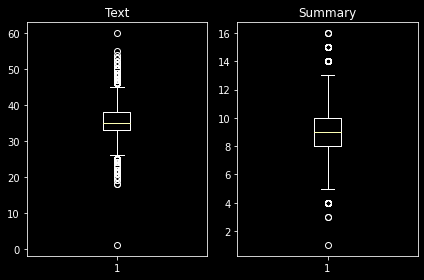

In [30]:
plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('Summary')
plt.tight_layout()
plt.show()

- 예제 데이터셋 대비 정규분포의 사분위 수의 분포는 넓은 편이다
- 아웃라이어 해당하는 길거나, 짧은 문장의 수가 적지는 않으나 좌우로 고르며, 아웃라이어간의 분포가 촘촘한 편
- 결과적으로 아웃라이어를 제어해 데이터의 일관성을 높이기에 비교적 용이해 보인다.

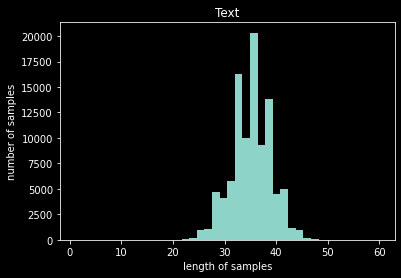

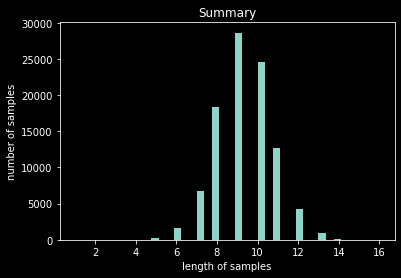

In [31]:
plt.title('Text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- 위의 내용을 bar차트로 더 뚜렷하게 확인해 볼 수 있다.
- 임의의 최대 길이를 설정해 확인해보는 과정의 숫자를 적절히 정하는데 참고하자

In [41]:
# 각 컬럼 문장 최대길이를 임의로 설정.
text_max_len = 48
summary_max_len = 13

In [42]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [43]:
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['Summary'])

전체 샘플 중 길이가 48 이하인 샘플의 비율: 0.9995729971533144
전체 샘플 중 길이가 13 이하인 샘플의 비율: 0.9981699877999186


In [45]:
# 정해진 길이보다 길면 학습에서 제외하는 식으로 정제 방식을 바꾸는 과정
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98138


길이에 제한을 두기 전과 비교해 손실이 거의 발생하지 않았다. 약간 미심쩍지만 일단 진행해보자.

#### 시작 토큰과 종료 토큰을 추가

In [46]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Summary,Text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


#### 먼저, 자료형을 배열로 변환하자

In [47]:
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

#### 데이터를 섞어주자

In [48]:
# encoder_input과 크기, 형태가 같은 순서가 섞인 정수 시퀀스를 생성
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[90895 48843 22771 ... 75242 26634 93413]


In [49]:
# 섞은 정수 시퀀스를 이용해 샘플 순서를 정의해주면, 잘 섞인 샘플이 되는 셈
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

=3


In [50]:
# 비율로 분리
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19627


In [51]:
# 임의로 정의한 테스트 데이터 개수를 이용해 전체 데이터를 슬라이싱
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78511
훈련 레이블의 개수 : 78511
테스트 데이터의 개수 : 19627
테스트 레이블의 개수 : 19627


In [128]:
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[   1 5529    3  740    4 1802    9 1139 1141    0    0    0    0]
 [   1   27 3782  158  235  352   14 3167    5  120   39    7    0]
 [   1   40 1273  342  468  542  485    8  159  669 3119    0    0]
 [   1 8621  187 8877 1860  501  933 1763  799  351    0    0    0]
 [  47 2247 2944    5   99  145   81 1040  178   80   10 2660  637]]
target
decoder  [[5529    3  740    4 1802    9 1139 1141    2    0    0    0    0]
 [  27 3782  158  235  352   14 3167    5  120   39    7    2    0]
 [  40 1273  342  468  542  485    8  159  669 3119    2    0    0]
 [8621  187 8877 1860  501  933 1763  799  351    2    0    0    0]
 [2247 2944    5   99  145   81 1040  178   80   10 2660  637    2]]


### 2.1.5. 정수형으로 인코딩
: 컴퓨터가 텍스트를 처리할 수 있도록 데이터의 단어들을 모두 정수로 바꾸어 준다.
- 단어 집합/단어장, 영어로는 vocabuary 를 만든다고 표현
- 케라스의 토크나이저를 사용

In [52]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

#### 저빈도 단어를 데이터셋에서 제거하자
- 바로 아래 코드는 지정한 횟수 미만으로 사용된 단어의 인덱스 비율과, 양적 비율을 보여준다.
- 양적 비율(빈도)가 5% 이하인 경우 제거하고 진행하도록 횟수를 비교 확인

In [64]:
threshold = 11
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69348
등장 빈도가 10번 이하인 희귀 단어의 수: 51912
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 17436
단어 집합에서 희귀 단어의 비율: 74.8572417373248
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.897053225005108


In [65]:
# 저빈도 단어를 제외하고 단어장을 재생성
src_vocab = 17400
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [66]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[128, 31, 2354, 162, 5371, 644, 866, 1528, 183, 605, 5283, 3950, 3628, 367, 2699, 4271, 1720, 3777, 145, 162, 67, 90, 3828, 569, 3140, 3123, 6106, 1783], [1966, 47, 14, 9088, 49, 2522, 1057, 8, 1027, 218, 62, 9447, 2016, 563, 406, 98, 7900, 362, 373, 80, 711, 2446, 4474, 2522, 4814, 1966, 47, 14, 38, 790, 275, 186], [187, 3255, 4815, 3354, 3986, 441, 526, 4815, 2057, 3355, 12936, 4815, 3354, 187, 3986, 8663, 12937, 12936, 1700, 2037, 572, 187, 3986, 72, 2700, 953, 8663, 1819, 453, 75, 6107]]


#### 헤드라인 데이터에 대해서도 동일한 작업을 진행해주자

In [68]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [71]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30153
등장 빈도가 5번 이하인 희귀 단어의 수: 19745
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10408
단어 집합에서 희귀 단어의 비율: 65.48270487182039
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.658782421052371


In [72]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 3034, 196, 4834, 3, 46, 831, 1092, 61], [1, 1567, 34, 1174, 69, 23, 1195, 7, 7233, 5, 1851], [1, 101, 2677, 228, 52, 3, 6478, 1613, 6, 2840, 503], [1, 894, 4, 4516, 76, 119, 309], [1, 55, 84, 5, 2341, 541, 333]]
target
decoder  [[3034, 196, 4834, 3, 46, 831, 1092, 61, 2], [1567, 34, 1174, 69, 23, 1195, 7, 7233, 5, 1851, 2], [101, 2677, 228, 52, 3, 6478, 1613, 6, 2840, 503, 2], [894, 4, 4516, 76, 119, 309, 2], [55, 84, 5, 2341, 541, 333, 2]]


#### 저빈도 단어를 제외하는 과정에서 생긴 빈 데이터를 제거해주자
: 길이가 짧았던 원본 데이터에서 저빈도 단어가 제거되며 빈 데이터가 생성되었을 수 있다. 특히 원래 길이가 짧은 헤드라인 데이터에서 이런 경우가 발생할 가능성이 크다.

- 시작토큰과 끝토큰(sostoken, eostoken)이 남아 있을 것이니 데이터의 최소 길이는 1인 상태

In [73]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78511
훈련 레이블의 개수 : 78511
테스트 데이터의 개수 : 19627
테스트 레이블의 개수 : 19627


#### 띠용.. 그런 케이스가 없었다.
- 예제의 데이터셋은 아마존 리뷰, 반면 프로젝트의 데이터셋은 뉴스기사
- 비교적 포멀한 뉴스기사의 경우 기본적으로 희귀한(빈도가 낮은) 어휘만으로 구성된 문장이 없었을 것으로 추측된다.

#### 패딩
: 최대 길이 문장에 맞게 짧은 문장들의 뒤에 0을 넣어 자료의 형태를 맞춰준다.

In [74]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

## 2.2. 모델 설계

- 아래 문서를 참조해 드룹아웃의 비율을 설정해 보았다.
>https://arxiv.org/pdf/1810.08606.pdf
    - 문서에서 다룬 데이터셋은 두 가지로, 이 프로젝트의 경우 SNLI를 참조하는 것이 적합하다.
        - SNLI는 두 문장 간의 상관관계를 분류하기 위한 예제 데이터셋이라고 한다.
        -  SciTail는 객관식 과학시험 문제와 웹에서 크롤링한 데이터를 대상으로 하는 언어적 연관성이 적은 데이터셋을 다룬다고 한다.
    - 임베딩, 어텐션, 드롭아웃을 모두 사용한 경우에 해당한다.(inter-어텐션과 intra-어텐션에 관해서는 정확한 정보를 얻지 못했다.)
- 또한 일반적으로 드롭아웃은 입력층에 가까울 때 비율을 크게하고 점진적으로 줄여나간다고 한다.


In [78]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.15, recurrent_dropout = 0.15)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.125, recurrent_dropout=0.125)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.1, recurrent_dropout=0.1)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

- hidden state
> hidden state는 LSTM에서 얼만큼의 수용력(capacity)를 가질지를 정하는 파라미터에요. 이 파라미터는 LSTM의 용량의 크기나, LSTM에서의 뉴런의 개수라고 이해하면 돼요. 

- dropout
> dropout은 레이어의 weight를 랜덤으로 생략하여 모델의 과적합(overfitting)을 해결해주는 방법

-  recurrent dropout
> recurrent dropout은 dropout을 레이어가 아닌 time step마다 해주는 방식이에요. 즉 time step의 입력을 랜덤으로 생략해 주는 거죠. recurrent dropout은 일반적인 dropout와 같이 regularization을 해주는 효과가 있고, 과적합을 방지할 수 있다고 해요.

In [79]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

- 디코더 출력층은 단어장에서 현재 토큰 다음에 올 토큰을 선택하는 것.
> Dense의 인자로 tar_vovab을 준다.
- 따라서 다중 분류문제로 볼 수 있다.
> 활성화 함수로 소프트맥스를 사용.

In [80]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 48)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 48, 128)      2227200     input_3[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 48, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

#### 어텐션 메커니즘의 적용

In [81]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 48)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 48, 128)      2227200     input_3[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 48, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

## 2.3. 학습!

- 조기종료(EarlyStopping)를 통해 필요 이상의 학습을 방지한다.
- 여기서 종료 조건은 val_loss가 감소하지 않는 경우가 2회 발생하는 경우로 두었다.

In [82]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
307/307 [==============================] - 222s 671ms/step - loss: 5.2286 - val_loss: 4.8269
Epoch 2/50
307/307 [==============================] - 203s 660ms/step - loss: 4.6589 - val_loss: 4.4355
Epoch 3/50
307/307 [==============================] - 202s 657ms/step - loss: 4.3207 - val_loss: 4.1796
Epoch 4/50
307/307 [==============================] - 201s 656ms/step - loss: 4.0746 - val_loss: 4.0271
Epoch 5/50
307/307 [==============================] - 201s 656ms/step - loss: 3.8799 - val_loss: 3.8848
Epoch 6/50
307/307 [==============================] - 201s 654ms/step - loss: 3.7176 - val_loss: 3.7800
Epoch 7/50
307/307 [==============================] - 201s 655ms/step - loss: 3.5767 - val_loss: 3.7049
Epoch 8/50
307/307 [==============================] - 200s 651ms/step - loss: 3.4532 - val_loss: 3.6319
Epoch 9/50
307/307 [==============================] - 201s 655ms/step - loss: 3.3425 - val_loss: 3.5764
Epoch 10/50
307/307 [==============================] - 201s 654m

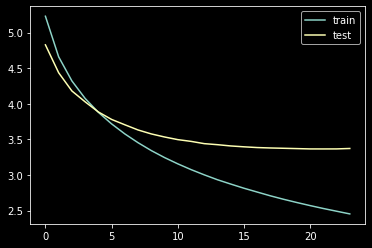

In [83]:
# 시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

- 24회의 epoch을 통해 loss값이 1.5이상 감소한 것은 우선 만족스럽다
- 반대로 생각하면 초기 손실이 너무 크다고 볼 수도 있을 것 같다.
- 긴 학습 시간 동안 데이터 전처리를 조금 더 정교하게 진행할 방법을 배웠던 것이 생각났다
    - 우선 padding의 인자를 post로 통일한 부분이 조금 마음에 걸린다. 
      <br>: 문장의 최대 길이 제한 상 1분위와 토큰 갯수 차이가 10 안밖이지만 데이터의 양과 RNN의 특성을 고려하면 인코딩 데이터의 패딩은 pre로 두는 것이 더 좋을 것 같다.
      
  - 다음으로 지나치게 짧은 길이의 문장도 제거해주는 전처리 과정을 거치면 좋을 것 같다
      <br>: 우리의 목적은 본문 텍스트와 헤드라인 텍스트의 상관성을 높이는 것이라 할 수 있다. 지나치게 짧은 본문텍스트를 가정해보면, 본문의 내용이 헤드라인에 반영되는 비율이 너무 클 가능성이 높아질 것임을 쉽게 상상할 수 있다.

#### Text 컬럼의 너무 짧은 문장 제거

- 앞서 사용한 최대 길이 이하 샘플 비율 계산 함수를 참조하자

      def below_threshold_len(max_len, nested_list):
       cnt = 0
       for s in nested_list:
         if(len(s.split()) <= max_len):
             cnt = cnt + 1
       print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))
       
- 물론, 최대/최소를 한 번에 받아 비율을 확인하는 것이 더 정확할 것이다. 
- 하지만 앞서 최대 길이 기준 비율이 99.99% 정도였으니 큰 차이는 없을 것
- 사실상 위의 분포 표를 보고 눈대중으로 최소치를 정해도 무방하지만, 
<br>최소치의 경우 Text컬럼에만 적용할 예정인 것 등의 차이가 있으니 점검해보자

In [87]:
def above_threshold_len(min_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) >= min_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이상인 샘플의 비율: %s'%(min_len, (cnt / len(nested_list))))

In [88]:
text_min_len = 23
above_threshold_len(text_min_len, data['Text'])

전체 샘플 중 길이가 23 이상인 샘플의 비율: 0.9995924106869918


In [91]:
print(text_max_len)

48


최대 길이 이하의 비율과 거의 비슷하게 조절해주었다.

    below_threshold_len(text_max_len, data['Text'])
    > 전체 샘플 중 길이가 48 이하인 샘플의 비율: 0.9995729971533144

In [105]:
# 사실 데이터를 새로 불러오지 않았으니 data변수에서 이미 max_len은 제거되어있다.
# 하지만 이외의 데이터 변수를 추가로 수정한 내역은 없으니 아래와 같이 가시적으로 수정.
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len \
            and len(x.split()) >= text_min_len)]

#### 데이터 변화를 반영하기 위해 앞서 작업을 반복해준다.

In [172]:
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [173]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[21459 82246 75758 ... 79369 18748 26801]


In [176]:
# 섞은 정수 시퀀스를 이용해 샘플 순서를 정의해주면, 잘 섞인 샘플이 되는 셈
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [177]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19619


- .. 극히 소폭 감소했다. (원래 19627이었음)

In [178]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78479
훈련 레이블의 개수 : 78479
테스트 데이터의 개수 : 19619
테스트 레이블의 개수 : 19619


- 훈련 데이터의 경우 약 50개 가량 감소했다(..)
- 하지만 아웃라이어의 제거인 만큼 효과가 있을 것이라 믿어보자.

In [182]:
src_tokenizer.fit_on_texts(encoder_input_train)

In [161]:
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train)
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

In [195]:
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

In [196]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78479
훈련 레이블의 개수 : 78479
테스트 데이터의 개수 : 19619
테스트 레이블의 개수 : 19619


### 인코더의 padding 인자를 pre로 수정해주자

In [115]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='pre')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='pre')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

#### 모델은 그대로
이긴 하지만.. 

데이터의 변화를 반영하고, 내 수준에서 파악하기 어려운 문제 발생을 피하기 위해 그대로 재실행.

In [116]:
# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.15, recurrent_dropout = 0.15)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.125, recurrent_dropout=0.125)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.1, recurrent_dropout=0.1)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

#### 디코더 레이어
를 보던 중 이곳의 드롭아웃 수치를 수정하지 않았음을 발견(..ㅠ)
- 적확한 비교를 위해 통제변인으로 두는 것이 타당하겠으나, 학습 시간이 너무 길기 때문에 처음 의도대로 수정함
     > dropout=0.4 -> 0.2  
     > recurrent_dropout=0.2 -> 0.1

In [117]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.2, recurrent_dropout=0.1)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [118]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델2로 정의해줌
model2 = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model2.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 48)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 48, 128)      2227200     input_5[0][0]                    
__________________________________________________________________________________________________
lstm_8 (LSTM)                   [(None, 48, 256), (N 394240      embedding_4[0][0]                
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

#### 어텐션 레이어(?) 결합

In [119]:
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model2 = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model2.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 48)]         0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 48, 128)      2227200     input_5[0][0]                    
__________________________________________________________________________________________________
lstm_8 (LSTM)                   [(None, 48, 256), (N 394240      embedding_4[0][0]                
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### 다시, 학습!

In [121]:
model2.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model2.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
307/307 [==============================] - 221s 695ms/step - loss: 5.3162 - val_loss: 4.9058
Epoch 2/50
307/307 [==============================] - 208s 676ms/step - loss: 4.9788 - val_loss: 4.6939
Epoch 3/50
307/307 [==============================] - 206s 672ms/step - loss: 4.6450 - val_loss: 4.3899
Epoch 4/50
307/307 [==============================] - 206s 670ms/step - loss: 4.3067 - val_loss: 4.1575
Epoch 5/50
307/307 [==============================] - 206s 671ms/step - loss: 4.0494 - val_loss: 4.0075
Epoch 6/50
307/307 [==============================] - 205s 669ms/step - loss: 3.8409 - val_loss: 3.8893
Epoch 7/50
307/307 [==============================] - 206s 670ms/step - loss: 3.6642 - val_loss: 3.7870
Epoch 8/50
307/307 [==============================] - 206s 671ms/step - loss: 3.5116 - val_loss: 3.7075
Epoch 9/50
307/307 [==============================] - 206s 670ms/step - loss: 3.3768 - val_loss: 3.6453
Epoch 10/50
307/307 [==============================] - 205s 669m

KeyboardInterrupt: 

#### 결과가..?
- 생각보다 너무 좋지 못하다. 특히 학습 초반부에 대한 예측이 완전히 빗나갔다.
- ES를 기다리는 시간이 아까워 v_loss가 처음 높아졌을 때 강제중단했다.
- 생각 해보면 rnn 모델에서 패당 post가 가지는 단점을 어텐션 모델이 어느 정도 상쇄한다.
- 또한 디코더 레이어는 임베딩 레이어를 제외하면 단층 신경망으로 구성되어 있다.
<br>이것을 고려한다면 드롭아웃의 비율을 과하게 줄인 것일 수 있을 것.

#### 디코딩 레이어의 드롭아웃을 원상복구하고 학습 진행

In [122]:
# 인코더
embedding_dim = 128
hidden_size = 256
# 인코더
encoder_inputs = Input(shape=(text_max_len,))
# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)
# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.15, recurrent_dropout = 0.15)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)
# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.125, recurrent_dropout=0.125)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)
# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.1, recurrent_dropout=0.1)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# 디코더
decoder_inputs = Input(shape=(None,))
# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)
# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 
# 모델2로 정의해줌
model2 = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)

#어텐션 레이어
attn_layer = AdditiveAttention(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])
# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)
# 모델 재정의 / 요약
model2 = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model2.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 48)]         0                                            
__________________________________________________________________________________________________
embedding_6 (Embedding)         (None, 48, 128)      2227200     input_7[0][0]                    
__________________________________________________________________________________________________
lstm_12 (LSTM)                  [(None, 48, 256), (N 394240      embedding_6[0][0]                
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [123]:
model2.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model2.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
307/307 [==============================] - 214s 671ms/step - loss: 5.3208 - val_loss: 4.9013
Epoch 2/50
307/307 [==============================] - 204s 665ms/step - loss: 4.9658 - val_loss: 4.6539
Epoch 3/50
307/307 [==============================] - 203s 662ms/step - loss: 4.5676 - val_loss: 4.3414
Epoch 4/50
307/307 [==============================] - 204s 664ms/step - loss: 4.2547 - val_loss: 4.1389
Epoch 5/50
307/307 [==============================] - 204s 665ms/step - loss: 4.0183 - val_loss: 3.9788
Epoch 6/50
307/307 [==============================] - 203s 661ms/step - loss: 3.8221 - val_loss: 3.8636
Epoch 7/50
307/307 [==============================] - 204s 664ms/step - loss: 3.6566 - val_loss: 3.7794
Epoch 8/50
307/307 [==============================] - 204s 664ms/step - loss: 3.5156 - val_loss: 3.7059
Epoch 9/50
307/307 [==============================] - 210s 684ms/step - loss: 3.3937 - val_loss: 3.6582
Epoch 10/50
307/307 [==============================] - 211s 687m

KeyboardInterrupt: 

#### 12epoch 진행후 중단
- 마찬가지로 초반부 학습에서의 격차를 거의 좁히지 못했다.
- 다만 디코딩레이어의 드롭아웃 레이트는 큰 영향을 까치지 않는 것을 확인 한 셈

### 학습 4회차
- 코드 동작 상의 문제가 있을 수 있겠다(..)
- 데이터를 다운받는 시점부터 재실행
- 조건은 2회차와 동일하게 한다

In [12]:
# 다운로드
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [13]:
print(data.columns)
data.columns = ['Summary', 'Text']
print(data['Text'].shape, data['Summary'].shape)

data.drop_duplicates(subset = ['Text'], inplace=True)
# data.drop_duplicates(subset = ['Summary'], inplace=True)
print('전체 샘플수 :', (len(data)))

print(data.isnull().sum())
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

print("정규화 사전의 수: ", len(contractions))
print('불용어 개수 :', len(stopwords.words('english')))
print(stopwords.words('english'))


Index(['headlines', 'text'], dtype='object')
(98401,) (98401,)
전체 샘플수 : 98360
Summary    0
Text       0
dtype: int64
전체 샘플수 : 98360


NameError: name 'contractions' is not defined

In [199]:
# 전처리 진행
# 요약컬럼은 불용어를 제거하지 않기 때문에, 이후 따로 호출해야 한다.

clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [200]:
clean_summary = []
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['Summary']:
    clean_summary.append(preprocess_sentence(s, False))

print("Summary 전처리 후 결과: ", clean_summary[:5])

Summary 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


In [225]:
data['Text'] = clean_text
data['Summary'] = clean_summary

In [32]:
text_len = [len(s.split()) for s in data['Text']]
summary_len = [len(s.split()) for s in data['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299532330215534


In [33]:
print(data.isnull().sum())
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

# 각 컬럼 문장 최대길이를 임의로 설정.
text_max_len = 48
summary_max_len = 13

Summary    0
Text       0
dtype: int64
전체 샘플수 : 98360


In [34]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [35]:
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len, data['Summary'])

전체 샘플 중 길이가 48 이하인 샘플의 비율: 0.9995729971533144
전체 샘플 중 길이가 13 이하인 샘플의 비율: 0.9981699877999186


In [36]:
def above_threshold_len(min_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) >= min_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이상인 샘플의 비율: %s'%(min_len, (cnt / len(nested_list))))

In [37]:
text_min_len = 23
above_threshold_len(text_min_len, data['Text'])

전체 샘플 중 길이가 23 이상인 샘플의 비율: 0.9995933306222041


In [38]:
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len and len(x.split()) >= text_min_len)]
data = data[data['Summary'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98098


In [56]:
text_max_len

48

In [39]:
below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len, data['Summary'])
above_threshold_len(text_min_len, data['Text'])

전체 샘플 중 길이가 48 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 13 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 23 이상인 샘플의 비율: 1.0


In [40]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Summary'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Summary'].apply(lambda x : x + ' eostoken')
data.head()

,Summary,Text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [41]:
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

# encoder_input과 크기, 형태가 같은 순서가 섞인 정수 시퀀스를 생성
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

# 섞은 정수 시퀀스를 이용해 샘플 순서를 정의해주면, 잘 섞인 샘플이 되는 셈
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

# 비율로 분리
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

# 임의로 정의한 테스트 데이터 개수를 이용해 전체 데이터를 슬라이싱
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

[  731   400  6191 ... 81565 60168 55539]
테스트 데이터의 수 : 19619
훈련 데이터의 개수 : 78479
훈련 레이블의 개수 : 78479
테스트 데이터의 개수 : 19619
테스트 레이블의 개수 : 19619
input
input  ['sostoken will encourage those who want to have four kids andhra cm'
 'sostoken anil to undergo treatment for shoulder calcification in germany'
 'sostoken named worst password again donald joins the list'
 'sostoken softbank investments have kept amazon at bay masayoshi son'
 'sostoken netflix ceo net worth hits record high at billion']
target
decoder  ['will encourage those who want to have four kids andhra cm eostoken'
 'anil to undergo treatment for shoulder calcification in germany eostoken'
 'named worst password again donald joins the list eostoken'
 'softbank investments have kept amazon at bay masayoshi son eostoken'
 'netflix ceo net worth hits record high at billion eostoken']


In [42]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [43]:
threshold = 11
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69625
등장 빈도가 10번 이하인 희귀 단어의 수: 52159
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 17466
단어 집합에서 희귀 단어의 비율: 74.91418312387792
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.900326647296074


In [44]:
src_vocab = 17400
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

In [45]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[845, 60, 77, 3392, 1394, 1, 203, 10, 82, 200, 5926, 306, 2614, 1347, 273, 2351, 273, 1629, 5981, 1394, 4, 5582, 2, 4805, 979, 187, 1315, 816, 870, 1607, 178, 870, 1], [825, 140, 79, 836, 17, 13, 5038, 2556, 323, 4237, 384, 902, 737, 197, 2327, 413, 2197, 825, 4, 825, 24, 2169, 3497, 1074, 1532, 29, 3, 316, 12576, 1523], [6193, 1149, 1821, 5430, 1176, 1336, 3, 279, 1821, 6113, 5, 34, 33, 7335, 51, 2037, 6113, 92, 817, 197, 5430, 124, 55, 549, 2446, 817, 32, 6, 945, 373]]


In [46]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [51]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30035
등장 빈도가 5번 이하인 희귀 단어의 수: 19606
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10429
단어 집합에서 희귀 단어의 비율: 65.27717662726819
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.6460908560622105


In [52]:
tar_vocab = 10431
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 24, 7636, 748, 41, 275, 3, 46, 966, 233, 351, 35], [1, 871, 3, 4543, 1261, 5, 6164, 4, 791], [1, 276, 1437, 5656, 809, 781, 986, 18, 393], [1, 849, 4846, 46, 2096, 272, 12, 8187, 9537, 135], [1, 2963, 69, 1234, 192, 210, 109, 327, 12, 196]]
target
decoder  [[24, 7636, 748, 41, 275, 3, 46, 966, 233, 351, 35, 2], [871, 3, 4543, 1261, 5, 6164, 4, 791, 2], [276, 1437, 5656, 809, 781, 986, 18, 393, 2], [849, 4846, 46, 2096, 272, 12, 8187, 9537, 135, 2], [2963, 69, 1234, 192, 210, 109, 327, 12, 196, 2]]


In [53]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 78479
훈련 레이블의 개수 : 78479
테스트 데이터의 개수 : 19619
테스트 레이블의 개수 : 19619


In [54]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='pre')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='pre')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

In [58]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 인코더
embedding_dim = 128
hidden_size = 256
# 인코더
encoder_inputs = Input(shape=(text_max_len,))
# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)
# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.15, recurrent_dropout = 0.15)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)
# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.125, recurrent_dropout=0.125)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)
# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.1, recurrent_dropout=0.1)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# 디코더
decoder_inputs = Input(shape=(None,))
# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)
# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.2, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 
# 모델4로 정의해줌
model4 = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)

from tensorflow.keras.layers import AdditiveAttention

#어텐션 레이어
attn_layer = AdditiveAttention(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])
# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)
# 모델 재정의 / 요약
model4 = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model4.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 48)]         0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 48, 128)      2227200     input_3[0][0]                    
__________________________________________________________________________________________________
lstm_4 (LSTM)                   [(None, 48, 256), (N 394240      embedding_2[0][0]                
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [253]:
model4.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model4.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
307/307 [==============================] - 218s 684ms/step - loss: 5.2909 - val_loss: 4.9906
Epoch 2/50
307/307 [==============================] - 207s 674ms/step - loss: 4.9251 - val_loss: 4.6784
Epoch 3/50
307/307 [==============================] - 204s 665ms/step - loss: 4.5378 - val_loss: 4.3288
Epoch 4/50
307/307 [==============================] - 204s 665ms/step - loss: 4.2312 - val_loss: 4.1167
Epoch 5/50
307/307 [==============================] - 204s 665ms/step - loss: 3.9991 - val_loss: 3.9530
Epoch 6/50
307/307 [==============================] - 203s 662ms/step - loss: 3.8084 - val_loss: 3.8213
Epoch 7/50
307/307 [==============================] - 204s 664ms/step - loss: 3.6476 - val_loss: 3.7274
Epoch 8/50
307/307 [==============================] - 204s 664ms/step - loss: 3.5090 - val_loss: 3.6515
Epoch 9/50
307/307 [==============================] - 204s 664ms/step - loss: 3.3886 - val_loss: 3.5861
Epoch 10/50
307/307 [==============================] - 204s 665m

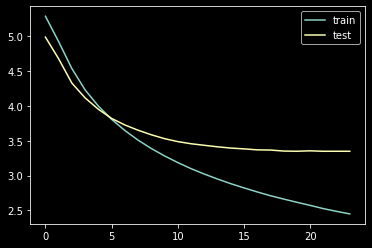

In [260]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [254]:
model4.save_weights('summary_bot_01')

#### 4회차 해석
- 데이터 다운로드부터 완전히 다시 진행했다.
- 결과적으로 향상이 있었고, 이전 시행에서 누락된 것이 무엇인지 찾아야 했다.
> 여러가지 의심되는 정황이 있었으나 특히 저빈도 토큰을 제거하는 과정이 누락되어있었다.
> 이후 실행했을 때에는 이미 이후 과정이 진행된 상태여서인지 전처리가 원활하지 못했다.
> 코드를 완전히 파악할 능력이 갖춰지기 전까지는 번거롭더라도 최대한 보수적으로 재실행 해야할 것 같다.
- 2회차에서 처음 예상 했던 것 처럼 padding을 pre로 바꾸는 것은 유효한 전략이었던 것 같다.
- 시작 로스값은 컸으나 감소폭이 높았고, 최초 대비 동일한 epoch에서 조기종료 되었다. 결과적으로 0.023 만큼의 놀라운(..)로스값 감소가 있었다.
- 모델 학 습 1회의 시간이 너무 오래걸리니 우선 결과물을 확인한 후에 추가적인 향상 방안을 생각해 보아야 할 것 같다.

### 2.4. 인퍼런스 모델 구현
- seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 한다


- 훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델 하나만 준비


- 그러나 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야한다.

In [255]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음


In [256]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [257]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [258]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

### 2.5. 모델 테스트

In [259]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [262]:
for i in range(100, 130):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : defending centre amid congress criticism rafale fighter aircraft deal indian air force chief bs dhanoa said deal central government negotiated good deal earlier congress vice president rahul gandhi alleged pm modi changed entire deal benefit one businessman later suggesting twitter anil ambani 
실제 요약 : rafale deal not govt well iaf chief 
예측 요약 :  rafale deal will be united to deal with rafale deal cong


원문 : madhya pradesh cm kamal nath monday said wants see gau cow shelters roads state review meeting nath said wished see cow shelters built district state cm also asked officials encourage state 
실제 요약 : want to see gau in shelters not on roads mp cm 
예측 요약 :  will not make one night in india if they are crime mp


원문 : facebook censored prize winning journalist matthew publishing series posts alleging corruption malta pm joseph muscat associates member team published panama papers temporarily locked facebook account four posts deleted violating social network community standards

- 해석에 앞서 시각적으로 요약의 성능이 영 별로라는 느낌이 드는 문장이 더러 보인다.
- 예측요약에서, 체감상 특히 길이가 짧은 어휘가 지나치게 반복되는 느낌이 든다.
- 하지만 개선을 위한 적절한 단서는 보이지 않는다.
- 마지막으로 옵티마이저를 adam으로 바꿔서 시도해 볼 것
> - 기본적으로 조금 더 빠른 속도를 기대할 수 있을 것
> - padding=pre, 어텐션 모델, rmsprop옵티마이저가 종합적으로 학습의 step을 너무 줄이는 것이 아닌가 하는 의심이 들기도 한다.

## 2.6. 추상적 요약 학습 재시도(5회차)
- 마침 커널이 사망한 바, 코드를 재실행 했음
- 노트북의 가독성이 너무 심하게 저하되는 바, 앞서 4회차의 셀을 재실행

In [67]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# 인코더
embedding_dim = 128
hidden_size = 256
# 인코더
encoder_inputs = Input(shape=(text_max_len,))
# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)
# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.15, recurrent_dropout = 0.15)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)
# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.125, recurrent_dropout=0.125)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)
# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.1, recurrent_dropout=0.1)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# 디코더
decoder_inputs = Input(shape=(None,))
# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)
# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 
# 모델5로 정의해줌
model5 = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)

from tensorflow.keras.layers import AdditiveAttention

#어텐션 레이어
attn_layer = AdditiveAttention(name='attention_layer')
# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])
# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)
# 모델 재정의 / 요약
model5 = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model5.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 48)]         0                                            
__________________________________________________________________________________________________
embedding_12 (Embedding)        (None, 48, 128)      2227200     input_13[0][0]                   
__________________________________________________________________________________________________
lstm_24 (LSTM)                  [(None, 48, 256), (N 394240      embedding_12[0][0]               
__________________________________________________________________________________________________
input_14 (InputLayer)           [(None, None)]       0                                            
___________________________________________________________________________________________

In [68]:
model5.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model5.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
307/307 [==============================] - 224s 705ms/step - loss: 5.4271 - val_loss: 5.0352
Epoch 2/50
307/307 [==============================] - 214s 696ms/step - loss: 4.9870 - val_loss: 4.8538
Epoch 3/50
307/307 [==============================] - 214s 697ms/step - loss: 4.7887 - val_loss: 4.6678
Epoch 4/50
307/307 [==============================] - 215s 699ms/step - loss: 4.5978 - val_loss: 4.5192
Epoch 5/50
307/307 [==============================] - 215s 700ms/step - loss: 4.4430 - val_loss: 4.4135
Epoch 6/50
307/307 [==============================] - 214s 696ms/step - loss: 4.3232 - val_loss: 4.3369
Epoch 7/50
 59/307 [====>.........................] - ETA: 2:48 - loss: 4.2166

KeyboardInterrupt: 

- 결과는 처참했다. 그리고 전혀 더 빠르지 않았다. 
- 수치를 개선하기 위한 솔루션은 잠시 미루고 우선 다음 스텝으로 넘어가기로 결정함.

## 3. 추출적 요약 해보기

In [69]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data2 = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
data2.columns = ['Summary', 'Text']
print(data2['Text'].shape, data2['Summary'].shape)

import requests
from summa.summarizer import summarize

(98401,) (98401,)


In [76]:
text_len = [len(s.split()) for s in data2['Text']]
summary_len = [len(s.split()) for s in data2['Summary']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 91
텍스트의 평균 길이 : 58.2385341612382
요약의 최소 길이 : 1
요약의 최대 길이 : 18
요약의 평균 길이 : 9.553906972490116


- 추출적 요약의 결과를 확인
- 10 개 정도의 기사를 추출해보자
- 전처리하지 않은 원본 데이터를 이용한다.
- 평균 길이를 감안해 ratio의 인자값을 설정.

In [82]:
import random
idx_num = [i for i in range(1,98402)]

for i in random.sample(idx_num, 10):
    print('본문 : ',data2['Text'].apply(str).iloc[i])
    print('헤드라인 : ',data2['Summary'].apply(str).iloc[i])
    print('요약 : ',summarize(data2['Text'].apply(str).iloc[i], ratio=0.163))
    print('\n\n\n')

본문 :  Pakistan's Ramiz Raja became the first batsman in ODIs to get out obstructing the field against England on November 20, 1987. Raja was batting on 98 before playing the match's last ball. While trying to take a second run to get to his century, Raja used his bat to prevent the ball from hitting wickets and was signalled out.
헤드라인 :  Pak batsman got out obstructing field running for 100th run
요약 :  




본문 :  US-based dog-sitting app Wag accidentally leaked personal information including home addresses of some of its users. The information of over 100 customers was posted on Wag's website and new records appeared on it everyday, according to reports. Acknowledging the leak, Wag said it happened because of a technical glitch in the software and added that no information has been misused.
헤드라인 :  Dog-sitting app Wag accidentally leaks users' home addresses
요약 :  




본문 :  A Thai woman, whose husband broadcast the murder of their 11-month-old daughter live on Facebook before committi

- 데이터의 평균 길이를 기준으로 비율은 0.163이 맞으나 그 수준에서는 거의 요약해내지 못한다.

In [89]:
import random
idx_num = [i for i in range(1,98402)]

for i in random.sample(idx_num, 10):
    print('본문 : ',data2['Text'].apply(str).iloc[i])
    print('헤드라인 : ',data2['Summary'].apply(str).iloc[i])
    print('요약 : ',summarize(data2['Text'].apply(str).iloc[i], ratio=0.34))
    print('\n\n\n')

본문 :  Three minor Dalit boys were stripped, beaten and paraded nude for allegedly swimming in a village well in Maharashtra's Vakadi on June 10. The boys can be seen wearing sandals and some tree leaves and being shouted at in videos of the incident which have emerged online. Two people have been arrested in the case. 
헤드라인 :  3 Dalit boys beaten, paraded naked for swimming in well
요약 :  Three minor Dalit boys were stripped, beaten and paraded nude for allegedly swimming in a village well in Maharashtra's Vakadi on June 10.




본문 :  When asked about his online security practices, Twitter CEO Jack Dorsey revealed that he doesn't use a laptop and does everything on his phone. He suggested he doesn't use a laptop for more work-life balance than security "The devices we have just have so much on them, so much interestingness, and you can certainly go down a hole," he added. 
헤드라인 :  I don't have a laptop: Twitter CEO Jack Dorsey
요약 :  




본문 :  Private sector lender Bandhan Bank has beco

- 데이터의 text 정도의 코퍼스를 대상으로는 약 1/3정도의 비율이 최소한으로 요구되는 듯하다
> 0.3의 경우에도 거의 요약하지 못함

- 나의 영어 독해실력과 요약의 수준이 막상막하인 것 같다.

## 4. 비교
추상적 요약 vs 추출적 요약
> 결과물을 가지고 비교하기에는 사실상 둘 다 수준이 너무 낮다.
> 그럼에도 각 방식의 일반적인 차이를 어느 정도 확인할 수 있는 부분도 있었다
    - 추출적 요약에 비해 추상적 요약이 본문의 어조를 어느 정도 더 반영한다
    - 충분한 성능을 내지 못한 추상적 요약의 경우(나의 경우..) 전혀 중요하지 않은 토큰으로 문장을 구성하는 경우가 많다.
> 추상적 요약 모델의 성능(손실 감소 뿐만 아니라 학습 속도)을 충분히 끌어내지 못한 만큼,
<br>개선의 여지가 크다고 생각된다.

## 5. 마치며

### 기억에 남는 학습 내용
- recurrent_dropout의 원리
- 어텐션을 통한 RNN 모델의 향상 가능성
- 코드의 흐름을 온전히 파악하지 못한 상태에서 중간부터 잘라다 쓰지 말자는 큰 교훈을 얻었다..

### 어려웠던 점
- 위 '기억에 남는 내용들'을 십분 활용하여 성능을 높이고 싶었으나, 실패..했다.
- 긴 학습시간 대비 교차검증 해야 할 변인이 너무 많다.
    > 사실상 학습용 데이터를 대상으로 한 것이 이 모양이니, 추후에 '진짜 데이터'를 대상으로 할 때를 대비해 이론적으로라도 많은 학습이 필요하다고 생각된다.


### 추가로 해보고 싶은 점
- 특정 요소 보다, 이번 exp는 꼭 만족할 만한 지표를 내어보고 싶다.


### 총평
1. 지표가 낮아서 자괴감
2. 모델 학습 시간이 길어지니 초조해지고, 초조해지니 자괴감
3. 명절 연휴에 밀린 학습을 소화하려고 했던 계획과, 또 마감에 시달리고 있는 현실에 자괴감

